# Testing decision tree decision path to compute infimum under $\nu$

In [1]:
from sklearn.tree import DecisionTreeRegressor
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import make_regression
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
import pandas as pd

from CP2LFI.scores import Scores, LambdaScore, WaldoScore, BFFScore
from CP2LFI.loforest import ConformalLoforest
from clover import LocartSplit

# importing functions to adapt estimated cutoffs
from CP2LFI.nuissance import TRUST_nuisance_cutoffs, TRUST_plus_nuisance_cutoff
from sklearn.ensemble import HistGradientBoostingRegressor

import torch
from CP2LFI.utils import fit_post_model
from torch.distributions.uniform import Uniform
from torch.distributions.poisson import Poisson
from torch.distributions.gamma import Gamma
import itertools
from tqdm import tqdm

## Testing CART atributes to compute nuisance cutoff:

In [2]:
# Simulate data using sklearn function
X_train, y_train = make_regression(n_samples=50, n_features=3, random_state=42)

# Create a decision tree regressor object
regressor = DecisionTreeRegressor(max_leaf_nodes=5, random_state=0)

# Fit the regressor to the training data
regressor.fit(X_train, y_train)

# Predict the target variable for the test data
X_test = np.array([[2, 3, 4], [5, 6, 7]])
y_pred = regressor.predict(X_test)

x[0] is our parameter os interest and x[1] and x[2] are nuissance:

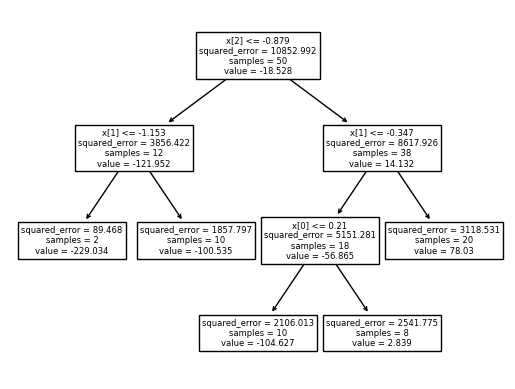

In [3]:
tree.plot_tree(regressor)
plt.show()

Exploring tree structure:

In [4]:
n_nodes = regressor.tree_.node_count
children_left = regressor.tree_.children_left
children_right = regressor.tree_.children_right
feature = regressor.tree_.feature
threshold = regressor.tree_.threshold
values = regressor.tree_.value

In [5]:
children_left

array([ 1,  7,  3,  5, -1, -1, -1, -1, -1], dtype=int64)

In [6]:
children_right

array([ 2,  8,  4,  6, -1, -1, -1, -1, -1], dtype=int64)

In [7]:
feature

array([ 2,  1,  1,  0, -2, -2, -2, -2, -2], dtype=int64)

In [8]:
threshold

array([-0.87932089, -1.1526942 , -0.34739607,  0.21025595, -2.        ,
       -2.        , -2.        , -2.        , -2.        ])

In [9]:
node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, 0)]  # start with the root node id (0) and its depth (0)

while len(stack) > 0:
    # `pop` ensures each node is only visited once
    node_id, depth = stack.pop()
    node_depth[node_id] = depth

    # If the left and right child of a node is not the same we have a split
    # node
    is_split_node = children_left[node_id] != children_right[node_id]
    # If a split node, append left and right children and depth to `stack`
    # so we can loop through them
    if is_split_node:
        stack.append((children_left[node_id], depth + 1))
        stack.append((children_right[node_id], depth + 1))
    else:
        is_leaves[node_id] = True

In [10]:
regressor.apply(X_test)

array([4, 4])

Exploring tree in each level:

In [11]:
print(
    "The binary tree structure has {n} nodes and has "
    "the following tree structure:\n".format(n=n_nodes)
)
for i in range(n_nodes):
    if is_leaves[i]:
        print(
            "{space}node={node} is a leaf node with value={value}.".format(
                space=node_depth[i] * "\t", node=i, value=values[i]
            )
        )
    else:
        print(
            "{space}node={node} is a split node with value={value}: "
            "go to node {left} if X[:, {feature}] <= {threshold} "
            "else to node {right}.".format(
                space=node_depth[i] * "\t",
                node=i,
                left=children_left[i],
                feature=feature[i],
                threshold=threshold[i],
                right=children_right[i],
                value=values[i],
            )
        )

The binary tree structure has 9 nodes and has the following tree structure:

node=0 is a split node with value=[[-18.52785519]]: go to node 1 if X[:, 2] <= -0.87932088971138 else to node 2.
	node=1 is a split node with value=[[-121.95151352]]: go to node 7 if X[:, 1] <= -1.152694195508957 else to node 8.
	node=2 is a split node with value=[[14.13224745]]: go to node 3 if X[:, 1] <= -0.3473960682749748 else to node 4.
		node=3 is a split node with value=[[-56.86472587]]: go to node 5 if X[:, 0] <= 0.2102559469640255 else to node 6.
		node=4 is a leaf node with value=[[78.02952343]].
			node=5 is a leaf node with value=[[-104.62743522]].
			node=6 is a leaf node with value=[[2.83866081]].
		node=7 is a leaf node with value=[[-229.03435438]].
		node=8 is a leaf node with value=[[-100.53494535]].


## Strategy to obtain nuisance-free cutoff:

### Implementing nuisance-adapted functions for each method

Implementing naive quantiles in the presence of nuisance parameter:

In [12]:
def naive_nuisance(
    kind,
    simulator,
    score,
    alpha,
    nuisance_idx,
    B=1000,
    N=100,
    naive_n=500,
    disable_tqdm=True,
    log_transf=False,
    X_mat = None,
    alpha_gamma = 1.5,
):
    n_grid = int(B / naive_n)
    quantiles = {}

    if kind == "poisson":
        # given the complexity, reducing to only 10 grid if B > 5000
        nu_grid = np.linspace(0.51, 1.49, int(np.ceil(n_grid ** (1 / 2))))
        mu_grid = np.linspace(0.1, 4.9, int(np.ceil(n_grid ** (1 / 2))))


        for nu, mu in tqdm(itertools.product(nu_grid, mu_grid), 
                           desc="fitting monte carlo cutoffs",
                           ):
            theta_fixed = torch.tensor([nu, mu])
            repeated_thetas = theta_fixed.reshape(1, -1).repeat_interleave(
                repeats=naive_n * N, dim=0
            )
            X_samples = simulator(repeated_thetas)

            if log_transf:
                X_samples = torch.log(X_samples)

            X_dim = X_samples.shape[1]
            X_samples = X_samples.reshape(naive_n, N * X_dim)

            lambdas = score.compute_nuissance(
            thetas=repeated_thetas.numpy()[0:naive_n, :],
                X=X_samples.numpy(), nuissance_idx = nuisance_idx, disable_tqdm=disable_tqdm, posterior_marginalized = True,
            )

            quantiles[(nu, mu)] = np.quantile(lambdas, q=1 - alpha)
    elif kind == "glm":
        # given the complexity, reducing to only 10 grid if B > 5000
        beta_grid = np.linspace(-1.90, 1.90, int(np.ceil(n_grid ** (1 / 2))))

        for beta_1, beta_2 in tqdm(itertools.product(beta_grid, beta_grid), 
                           desc="fitting monte carlo cutoffs",
                           ):
            theta_fixed = torch.tensor([beta_1, beta_2], dtype = torch.float32)
            repeated_thetas = theta_fixed.reshape(1, -1).repeat_interleave(
                repeats=naive_n, dim=0
            )
            Y_samples = simulator(repeated_thetas, X_mat, alpha = alpha_gamma)

            if log_transf:
                Y_samples = torch.log(Y_samples)

            lambdas = score.compute_nuissance(
            thetas=repeated_thetas.numpy()[0:naive_n, :],
                X=Y_samples.numpy(), nuissance_idx = nuisance_idx, disable_tqdm=disable_tqdm, posterior_marginalized = True,
            )

            quantiles[(beta_1, beta_2)] = np.quantile(lambdas, q=1 - alpha)

    # TODO: glm with five parameters
    return quantiles

def predict_naive_quantile(kind, theta_grid, quantiles_dict):
    thetas_values = np.array(list(quantiles_dict.keys()))
    quantiles_list = []
    for theta in theta_grid:
        if kind == "weinberg":
            idx = thetas_values[int(np.argmin(np.abs(theta - thetas_values)))]
            quantiles_list.append(quantiles_dict[idx])
        else:
            distances = np.linalg.norm(thetas_values - theta, axis=1)
            idx = thetas_values[np.argmin(distances)]
            quantiles_list.append(quantiles_dict[tuple(idx)])
    return quantiles_list

Implementing all methods nuisance cutoffs:

In [13]:
def TRUST_nuisance_cutoffs(
        trust_obj, 
        nuissance_idx,
        par_values,
        trust_quantiles,
        ):
    # returning all thresholds
    feature_array = np.array(trust_obj.cart.tree_.feature)
    threshold_array = np.array(trust_obj.cart.tree_.threshold)

    # cutoff array
    cutoff_nuis = np.zeros(par_values.shape[0])
    

    # selecting threshold_array with feature array equal to nuissance idx
    if isinstance(nuissance_idx, int):
        idxs = np.where(feature_array == nuissance_idx)
        thres = threshold_array[idxs]

        # choosing eps by pairwise distances
        dists = pairwise_distances(thres.reshape(-1, 1))
        upper_triangular_indices = np.triu_indices(dists.shape[0], k=1)
        eps = np.min(dists[upper_triangular_indices])*1/3

        nuis_values = np.concatenate((thres - eps, thres + eps), axis = None)

        # returning all index
        size = par_values.shape[1] + 1
        # idx list
        idx_array = np.arange(0, size)
        par_idx = idx_array[np.where(idx_array != nuissance_idx)]
        par_reorder = np.concatenate((par_idx, nuissance_idx), axis = None)

        i = 0
        for par in par_values:
            par_array = np.tile(par, reps = (nuis_values.shape[0], 1))
            new_par = np.column_stack((par_array, nuis_values))

            # reordering columns
            new_par = new_par[:, par_reorder]

            # computing cutoffs for new par
            idxs = trust_obj.cart.apply(new_par)
            list_locart_quantiles = np.array([trust_quantiles[idx] for idx in idxs])

            # returning minimal value
            cutoff_nuis[i] = np.max(list_locart_quantiles)
            i += 1
    else:
        idxs = np.where(feature_array == nuissance_idx)
        thres = threshold_array[idxs]
        # TODO obtaining all combinations using itertools
        nuis_values = np.concatenate((thres - eps, thres + eps), axis = None)
    
    return cutoff_nuis

def TRUST_plus_nuisance_cutoff(
        trust_plus_obj,
        nuissance_idx,
        par_values,
        K = 100,
        ):
    threshold_list = []
    feature_list = []
    # returning all thresholds for each tree
    for tree in trust_plus_obj.RF.estimators_:
        feature_array = np.array(tree.tree_.feature)
        threshold_array = np.array(tree.tree_.threshold)

        idxs = np.where(feature_array == nuissance_idx)
        thres = threshold_array[idxs]
        feature_nuis = feature_array[idxs]

        

        threshold_list.extend(list(thres))
        feature_list.extend(list(feature_nuis))

    # cutoff array
    cutoff_nuis = np.zeros(par_values.shape[0])

    # selecting threshold_array with feature array equal to nuissance idx
    if isinstance(nuissance_idx, int):
        thres = np.array(threshold_list)

        # choosing eps by pairwise distances
        dists = pairwise_distances(thres.reshape(-1, 1))
        upper_triangular_indices = np.triu_indices(dists.shape[0], k=1)
        eps = np.min(dists[upper_triangular_indices])*1/3

        nuis_values = np.concatenate((thres - eps, thres + eps), axis = None)

        # returning all index
        size = par_values.shape[1] + 1
        # idx list
        idx_array = np.arange(0, size)
        par_idx = idx_array[np.where(idx_array != nuissance_idx)]
        par_reorder = np.concatenate((par_idx, nuissance_idx), axis = None)

        i = 0
        for par in tqdm(par_values, desc = "Computing nuisance cutoffs for each parameter value"):
            par_array = np.tile(par, reps = (nuis_values.shape[0], 1))
            new_par = np.column_stack((par_array, nuis_values))

            # reordering columns
            new_par = new_par[:, par_reorder]

            # computing cutoffs for new par
            cutoff_vector = trust_plus_obj.compute_cutoffs(new_par, K = K)

            # returning minimal value
            cutoff_nuis[i] = np.max(cutoff_vector)
            i += 1
    else:
        idxs = np.where(feature_array == nuissance_idx)
        thres = threshold_array[idxs]
        # TODO obtaining all combinations using itertools
        nuis_values = np.concatenate((thres - eps, thres + eps), axis = None)
    
    return cutoff_nuis

def boosting_nuisance_cutoff(
        boosting_obj,
        nuisance_grid,
        nuissance_idx,
        par_values,
        ):
    # cutoff array
    cutoff_nuis = np.zeros(par_values.shape[0])

    if isinstance(nuissance_idx, int):
        # returning all index
        size = par_values.shape[1] + 1
        # idx list
        idx_array = np.arange(0, size)
        par_idx = idx_array[np.where(idx_array != nuissance_idx)]
        par_reorder = np.concatenate((par_idx, nuissance_idx), axis = None)

        i = 0
        for par in tqdm(par_values, desc = "Computing nuisance cutoffs for each parameter value in boosting"):
            par_array = np.tile(par, reps = (nuisance_grid.shape[0], 1))
            new_par = np.column_stack((par_array, nuisance_grid))

            # reordering columns
            new_par = new_par[:, par_reorder]

            # computing cutoffs for new par
            cutoff_vector = boosting_obj.predict(new_par)

            # returning minimal value
            cutoff_nuis[i] = np.max(cutoff_vector)
            i += 1
        return cutoff_nuis
    # TODO: nuisance with more than 1 dimension

def naive_nuisance_cutoff(
        naive_quantiles,
        nuisance_grid,
        nuisance_idx,
        par_values,
):
    # cutoff array
    cutoff_nuis = np.zeros(par_values.shape[0])

    if isinstance(nuisance_idx, int):
        # returning all index
        size = par_values.shape[1] + 1
        # idx list
        idx_array = np.arange(0, size)
        par_idx = idx_array[np.where(idx_array != nuisance_idx)]
        par_reorder = np.concatenate((par_idx, nuisance_idx), axis = None)

        i = 0
        for par in tqdm(par_values, desc = "Computing nuisance cutoffs for each parameter value in boosting"):
            par_array = np.tile(par, reps = (nuisance_grid.shape[0], 1))
            new_par = np.column_stack((par_array, nuisance_grid))

            # reordering columns
            new_par = new_par[:, par_reorder]

            # computing cutoffs with naive
            cutoff_vector = np.array(predict_naive_quantile(kind = "poisson", theta_grid = new_par, quantiles_dict = naive_quantiles))

            # returning minimal value
            cutoff_nuis[i] = np.max(cutoff_vector)
            i += 1
        return cutoff_nuis
    # TODO: nuisance with more than 1 dimension

Function to compute coverage and real nuisance cutoff:

In [14]:
def coverage_nuisance(cutoff_array_trust, 
                      cutoff_array_trust_plus,
                      cutoff_boosting,
                      cutoff_naive,
                      valid_thetas,
                      par_space,
                      score,
                      simulator,
                      nuisance_idx,
                      par_idx,
                      n_lambda = 1000,
                      n = 5,
                      glm = False,
                      X_mat = None,
                      alpha_gamma = 1.5):
    
    coverage_trust, coverage_trust_plus = np.zeros(valid_thetas.shape[0]), np.zeros(valid_thetas.shape[0])
    coverage_boosting, coverage_naive = np.zeros(valid_thetas.shape[0]), np.zeros(valid_thetas.shape[0])
    cutoff_trust_list, cutoff_trust_plus_list = [], []
    real_cutoff_list, boosting_cutoff_list = [], []
    naive_cutoff_list = []
    stat_list, mu_list, problem_cutoff = [], [], []
    i = 0

    # computing coverage for trust, trust++, boosting and naive
    for theta in tqdm(valid_thetas, desc = "Assessing "):
        cut_idx = np.where(par_space == theta[par_idx])
        # generating stats
        if glm:
            theta_repeated = torch.tensor([theta], dtype = torch.float32).reshape(1, -1).repeat_interleave(repeats = n_lambda, dim = 0)
            X_net = simulator(
                theta_repeated, 
                X_mat = X_mat, 
                alpha = alpha_gamma
                )
        else:
            theta_repeated = torch.tensor([theta], dtype = torch.float32).reshape(1, -1).repeat_interleave(repeats = n_lambda*n, dim = 0)
            X_net = simulator(theta_repeated)
            X_dim = X_net.shape[1]
            X_net = X_net.reshape(n_lambda, n * X_dim)

        stat = score.compute_nuissance(
            theta_repeated.numpy()[0:n_lambda,:], 
            X_net.numpy(), 
            nuissance_idx = nuisance_idx, 
            disable_tqdm = True,
            posterior_marginalized=True,
            )
        
        real_cutoff = np.quantile(stat, q = 0.95)
        coverage_trust[i] = np.mean(stat <= cutoff_array_trust[cut_idx])
        coverage_trust_plus[i] = np.mean(stat <= cutoff_array_trust_plus[cut_idx])
        coverage_boosting[i] = np.mean(stat <= cutoff_boosting[cut_idx])
        coverage_naive[i] = np.mean(stat <= cutoff_naive[cut_idx])

        # detecting cases where coverage is zero in TRUST
        if coverage_trust[i] < 0.1:
            stat_list.append(stat)
            mu_list.append(theta[1])
            problem_cutoff.append(cutoff_array_trust[cut_idx])
        
        # adding every cutoff in the list
        cutoff_trust_plus_list.append(cutoff_array_trust_plus[cut_idx])
        boosting_cutoff_list.append(cutoff_boosting[cut_idx])
        naive_cutoff_list.append(cutoff_naive[cut_idx])

        # returning cutoff for TRUST to evaluate
        cutoff_trust_list.append(cutoff_array_trust[cut_idx])
        real_cutoff_list.append(real_cutoff)
        i += 1
    
    # transforming the lists into arrays
    trust_grid_cutoff_array = np.array(cutoff_trust_list)
    trust_grid_plus_cutoff_array = np.array(cutoff_trust_plus_list)
    boosting_cutoff_array = np.array(boosting_cutoff_list)
    naive_cutoff_array = np.array(naive_cutoff_list)
    
    # computing real nuisance cutoff using real cutoffs from past loop
    real_cutoff =  np.array(real_cutoff_list)
    real_nuisance_cutoff_list = []
    for theta in tqdm(valid_thetas, desc = "Computing real cutoffs: "):
        cut_idxs = np.where(valid_thetas[:, par_idx] == theta[par_idx])
        real_nuisance_cutoff = np.max(real_cutoff[cut_idxs])
        real_nuisance_cutoff_list.append(real_nuisance_cutoff)
    
    # transforming the list into array
    real_grid_cutoff_array = np.array(real_nuisance_cutoff_list)
    
    # computing TRUST, TRUST++, Boosting and real cutoffs only for mu
    # in poisson example
    if not glm:
        real_mu_list, trust_mu_list, trust_plus_mu_list = [], [], []
        boosting_mu_list = []
        for mu in tqdm(par_space, desc = "Computing cutoffs only for mu: "):
            cut_idx = np.where(valid_thetas[:, 1] == mu)
            real_mu_nuisance_cutoff = np.unique(
                real_grid_cutoff_array[cut_idx])[0]
            trust_mu_nuisance_cutoff = np.unique(
                trust_grid_cutoff_array[cut_idx])[0]
            trust_plus_mu_nuisance_cutoff = np.unique(
                trust_grid_plus_cutoff_array[cut_idx])[0]
            boosting_mu_nuisance_cutoff = np.unique(
                boosting_cutoff_array[cut_idx])[0]
            

            boosting_mu_list.append(boosting_mu_nuisance_cutoff)
            real_mu_list.append(real_mu_nuisance_cutoff)
            trust_mu_list.append(trust_mu_nuisance_cutoff)
            trust_plus_mu_list.append(trust_plus_mu_nuisance_cutoff)

        # trust coverage, trus plus coverage, trust cutoff, nuisance cutoff, 
        # trust plus cutoff, real cutoff for mu, trust cutoff for mu and
        # trust plus cutoff for mu
            return [coverage_trust, 
            coverage_trust_plus,
            trust_grid_cutoff_array, 
            real_grid_cutoff_array,
            trust_grid_plus_cutoff_array,
            np.array(real_mu_list),
            np.array(trust_mu_list),
            np.array(trust_plus_mu_list),
            stat_list,
            mu_list,
            problem_cutoff,
            coverage_boosting, #11
            boosting_cutoff_array, #12
            coverage_naive, #13
            naive_cutoff_array, #14
            ]
    else:
        # trust coverage, trus plus coverage, trust cutoff, nuisance cutoff, 
        # trust plus cutoff
        return [coverage_trust, 
            coverage_trust_plus,
            trust_grid_cutoff_array, #2
            real_grid_cutoff_array, #3
            trust_grid_plus_cutoff_array, #4
            stat_list,
            mu_list,
            problem_cutoff,
            coverage_boosting, #8
            boosting_cutoff_array, #9
            coverage_naive, #10
            naive_cutoff_array, #11
            ]

Function to compute distance to oracle coverage:

In [15]:
def oracle_dist(coverage_array_trust, 
                coverage_array_trust_plus,
                coverage_boosting,
                coverage_naive,
                cutoff_real,
                valid_thetas,
                simulator,
                score,
                nuisance_idx,
                seed = None,
                n_lambda = 1000,
                n_rep = 50,
                n = 5,
                glm = False,
                X_mat = None,
                alpha_gamma = 1.5,
                ):
    
    if seed is not None:
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
    
    mean_diff_trust, mean_diff_trust_plus = np.zeros(n_rep), np.zeros(n_rep)
    mean_diff_boosting, mean_diff_naive= np.zeros(n_rep), np.zeros(n_rep)

    for i in tqdm(range(0, n_rep), desc = "Repeating computation: "):
        diff_trust, diff_trust_plus = np.zeros(valid_thetas.shape[0]), np.zeros(valid_thetas.shape[0])
        diff_boosting, diff_naive = np.zeros(valid_thetas.shape[0]), np.zeros(valid_thetas.shape[0])
        j = 0
        # computing coverage for trust, trust++ and boosting
        for theta in valid_thetas:
            if not glm:
                # generating stats
                theta_repeated = torch.tensor([theta]).reshape(1, -1).repeat_interleave(repeats = n_lambda*n, dim = 0)

                X_net = simulator(theta_repeated)
                X_dim = X_net.shape[1]
                X_net = X_net.reshape(n_lambda, n * X_dim)
            else:
                # generating stats
                theta_repeated = torch.tensor([theta], dtype = 
                                              torch.float32).reshape(1, -1).repeat_interleave(repeats = n_lambda, dim = 0)

                X_net = simulator(theta_repeated, X_mat = X_mat, 
                                  alpha = alpha_gamma,)

            stat = score.compute_nuissance(
                theta_repeated.numpy()[0:n_lambda,:], 
                X_net.numpy(), 
                nuissance_idx = nuisance_idx, 
                disable_tqdm = True,
                posterior_marginalized=True,
                )
            
            # real coverage
            oracle_coverage = np.mean(stat <= cutoff_real[j])
            
            diff_trust[j] = np.abs(coverage_array_trust[j] - oracle_coverage)
            diff_trust_plus[j] = np.abs(
                coverage_array_trust_plus[j] - oracle_coverage)
            diff_boosting[j] = np.abs(coverage_boosting[j] - oracle_coverage)
            diff_naive[j] = np.abs(coverage_naive[j] - oracle_coverage)
            j += 1

        mean_diff_trust[i] = np.mean(diff_trust)
        mean_diff_trust_plus[i] = np.mean(diff_trust_plus)
        mean_diff_boosting[i] = np.mean(diff_boosting)
        mean_diff_naive[i] = np.mean(diff_naive)
    
    mean_diff_trust_overall = np.mean(mean_diff_trust)
    mean_diff_trust_plus_overall= np.mean(mean_diff_trust_plus)
    mean_diff_boosting_overall = np.mean(mean_diff_boosting)
    mean_diff_naive_overall = np.mean(mean_diff_naive)

    n_exp = np.sqrt(n_rep)
    se_trust = 2*np.std(mean_diff_trust)/n_exp
    se_trust_plus = 2*np.std(mean_diff_trust_plus)/n_exp
    se_boosting = 2*np.std(mean_diff_boosting)/n_exp
    se_naive = 2*np.std(mean_diff_naive)/n_exp



    diff_data = pd.DataFrame({
        "methods": ["TRUST", "TRUST++", "Boosting", "MC"],
        "diff": [
            mean_diff_trust_overall, 
            mean_diff_trust_plus_overall, 
            mean_diff_boosting_overall, 
            mean_diff_naive_overall,
            ],
        "se*2": [se_trust, se_trust_plus, se_boosting, se_naive]
    })
    
    return [diff_trust,
            diff_trust_plus,
            diff_boosting,
            diff_naive,
            diff_data
            ]

We can obtain nuissance-free cutoff through minimizing cutoff over all possible threshold values for the nuissance parameter $\nu$. Testing this approach in a simple nuissance example:

### Poisson model with two parameters, one nuisance:

In [12]:
# nu parameter space and prior: (0, 1.5)
# mu parameter space and prior: (0, 5)
# hyperparameters fixed: s = 15, b = 70, tau = 1 (same as the LF2I paper)
def prior(n):
    m = Uniform(torch.tensor([0.5, 0.0]), torch.tensor([1.5, 5.0]))
    return m.sample(n)

def simulator(theta, s = 15, b = 70, tau = 1):
    b_par = theta[:,0]*b*tau
    s_par = theta[:,0]*b + theta[:, 1]*s
    par = torch.stack((b_par, s_par), -1).float()
    m = Poisson(par)
    return m.sample()

fitting posterior estimator only on $\mu$:

Fitting normalizing flows posterior estimator:  21%|██▏       | 426/2000 [01:37<05:59,  4.38it/s]

Early stopping at epoch 426
a


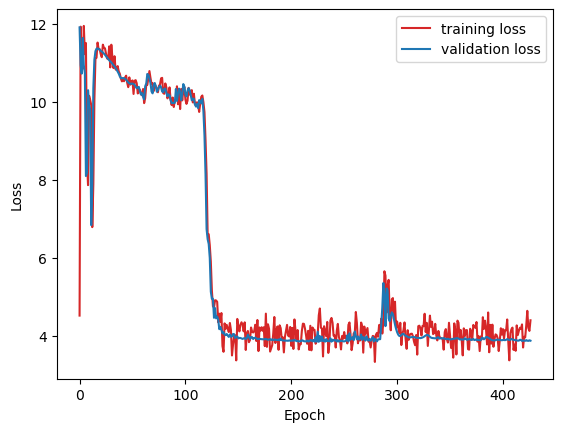

In [13]:
nflow_poisson_model = fit_post_model(
    simulator, 
    prior, 
    B_model = 25000, 
    n = 5, 
    seed = 125,
    nuisance_idx = 0, 
    split_seed = 45,
    patience = 200,
    n_flows = 4,
    poisson = True)

Fitting BFF score and setting $B$ and $n$ to fit our methods:

In [14]:
bff_score = BFFScore(nflow_poisson_model, is_fitted = True)
bff_score.fit()
B = 10000
n  = 5

Creating samples to train both TRUST and TRUST++ with majority votes:

In [15]:
torch.manual_seed(125)
torch.cuda.manual_seed(125)

print("Sampling from the parameter prior:")
thetas_sim = prior((B, ))

if thetas_sim.ndim == 1:
    model_thetas = thetas_sim.reshape(-1, 1)
else:
    model_thetas = thetas_sim

repeated_thetas = thetas_sim.repeat_interleave(repeats=n, dim=0)
X_net = simulator(repeated_thetas)
X_dim = X_net.shape[1]
X_net = X_net.reshape(B, n * X_dim)

print("Obtaining statistics sample: ")
model_lambdas = bff_score.compute_nuissance(
    model_thetas.numpy(), X_net.numpy(), nuissance_idx = 0, disable_tqdm=False, posterior_marginalized = True,
    )

print("Fitting our methods: ")
print("Fitting TRUST ")
trust_object = LocartSplit(
        LambdaScore, None, alpha=0.05, is_fitted=True, split_calib=False
    )
trust_quantiles = trust_object.calib(
    model_thetas.numpy(), model_lambdas, min_samples_leaf=300
)

# loforest quantiles
print("Fitting TRUST++")
trust_plus_object = ConformalLoforest(
    LambdaScore, None, alpha=0.05, is_fitted=True, split_calib=False
)
trust_plus_object.calibrate(
    model_thetas.numpy(),
    model_lambdas,
    min_samples_leaf=300,
    n_estimators=200,
    K=100,
)

# training boosting
boosting_object =  HistGradientBoostingRegressor(
        loss="quantile",
        max_iter=100,
        max_depth=3,
        quantile= 0.95,
        random_state=105,
        n_iter_no_change=15,
        early_stopping=True,
    )
boosting_object.fit(model_thetas.numpy(), model_lambdas)

Sampling from the parameter prior:
Obtaining statistics sample: 
Fitting our methods: 
Fitting TRUST 
Fitting TRUST++


HistGradientBoostingRegressor(early_stopping=True, loss='quantile', max_depth=3,
                              n_iter_no_change=15, quantile=0.95,
                              random_state=105)

Fitting naive quantiles:

In [17]:
naive_quantiles = naive_nuisance(
        kind="poisson",
        simulator=simulator,
        score = bff_score,
        nuisance_idx=0,
        alpha=0.05,
        B=B,
        N=n,
        naive_n=500,
        log_transf=False,
    )

fitting monte carlo cutoffs: 25it [00:00, 90.36it/s]


Fitting TRUST, TRUST++ and Boosting nuisance cutoffs:

In [19]:
nu_space = np.linspace(0.55, 1.49, 75)
mu_space = np.linspace(0.1, 4.85, 75)

# returning all combinations for fitting nuissance cutoffs
valid_thetas = np.c_[list(itertools.product(nu_space, mu_space))]

# returning meshgrid for plotting
mu_v, nu_v = np.meshgrid(mu_space, nu_space)

# obtaining cutoffs for each mu
cutoff_mu_TRUST = TRUST_nuisance_cutoffs(
    trust_object, 
    nuissance_idx = 0, 
    par_values = mu_space.reshape(-1, 1), 
    trust_quantiles = trust_quantiles, 
    )

cutoff_mu_TRUST_plus = TRUST_plus_nuisance_cutoff(
    trust_plus_object,
    nuissance_idx = 0,
    par_values = mu_space.reshape(-1, 1),
    K = 100,
)

cutoff_mu_boosting = boosting_nuisance_cutoff(
    boosting_object, 
    nuisance_grid = np.linspace(0.55, 1.49, 100), 
    nuissance_idx=0,
    par_values = mu_space.reshape(-1, 1),
    )

Computing nuisance cutoffs for each parameter value: 100%|██████████| 75/75 [05:13<00:00,  4.18s/it]
Computing nuisance cutoffs for each parameter value in boosting: 100%|██████████| 75/75 [00:00<00:00, 1135.15it/s]


Computing nuisance cutoffs:

In [20]:
cutoff_mu_naive = naive_nuisance_cutoff(
    naive_quantiles,
    nuisance_grid=np.linspace(0.55, 1.49, 100),
    nuisance_idx = 0,
    par_values = mu_space.reshape(-1, 1),
)

Computing nuisance cutoffs for each parameter value in boosting: 100%|██████████| 75/75 [00:00<00:00, 1204.90it/s]


Analysing coverage:

In [21]:
nuisance_poisson_list = coverage_nuisance(
    cutoff_mu_TRUST, 
    cutoff_mu_TRUST_plus,
    cutoff_mu_boosting, 
    cutoff_mu_naive,
    valid_thetas, 
    par_space = mu_space,
    par_idx = 1,
    nuisance_idx = 0,
    simulator = simulator,
    glm = False,
    score = bff_score,
    n_lambda = 1000,
    ) 

Assessing :   0%|          | 0/5625 [00:00<?, ?it/s]/tmp/ipykernel_7005/236229818.py:21: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1708025842427/work/torch/csrc/utils/tensor_new.cpp:275.)
  theta_repeated = torch.tensor([theta]).reshape(1, -1).repeat_interleave(repeats = n_lambda*n, dim = 0)
Computing cutoffs only for mu: 100%|██████████| 75/75 [00:00<00:00, 25909.96it/s]


Plotting coverage for every combination of $\nu$ and $\mu$:

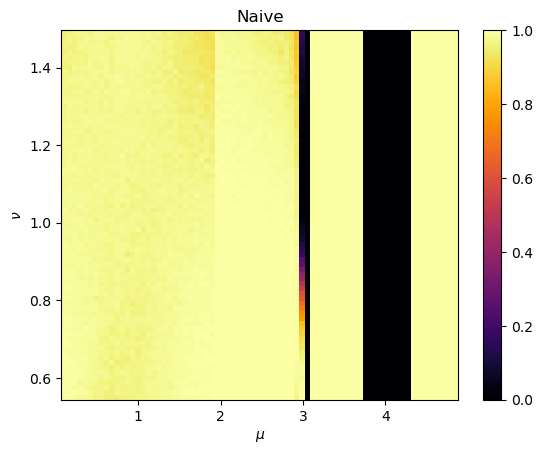

In [25]:
z = nuisance_poisson_list[13].reshape(75, 75)


fig = plt.figure()
pc = plt.pcolormesh(mu_v, 
                    nu_v, 
                    z, 
                    vmin= np.min(nuisance_poisson_list[13]),
                    vmax=1,
                    cmap = "inferno")
fig.colorbar(pc)
plt.ylabel(r'$\nu$')
plt.xlabel(r'$\mu$')
plt.title('Naive')
plt.show()

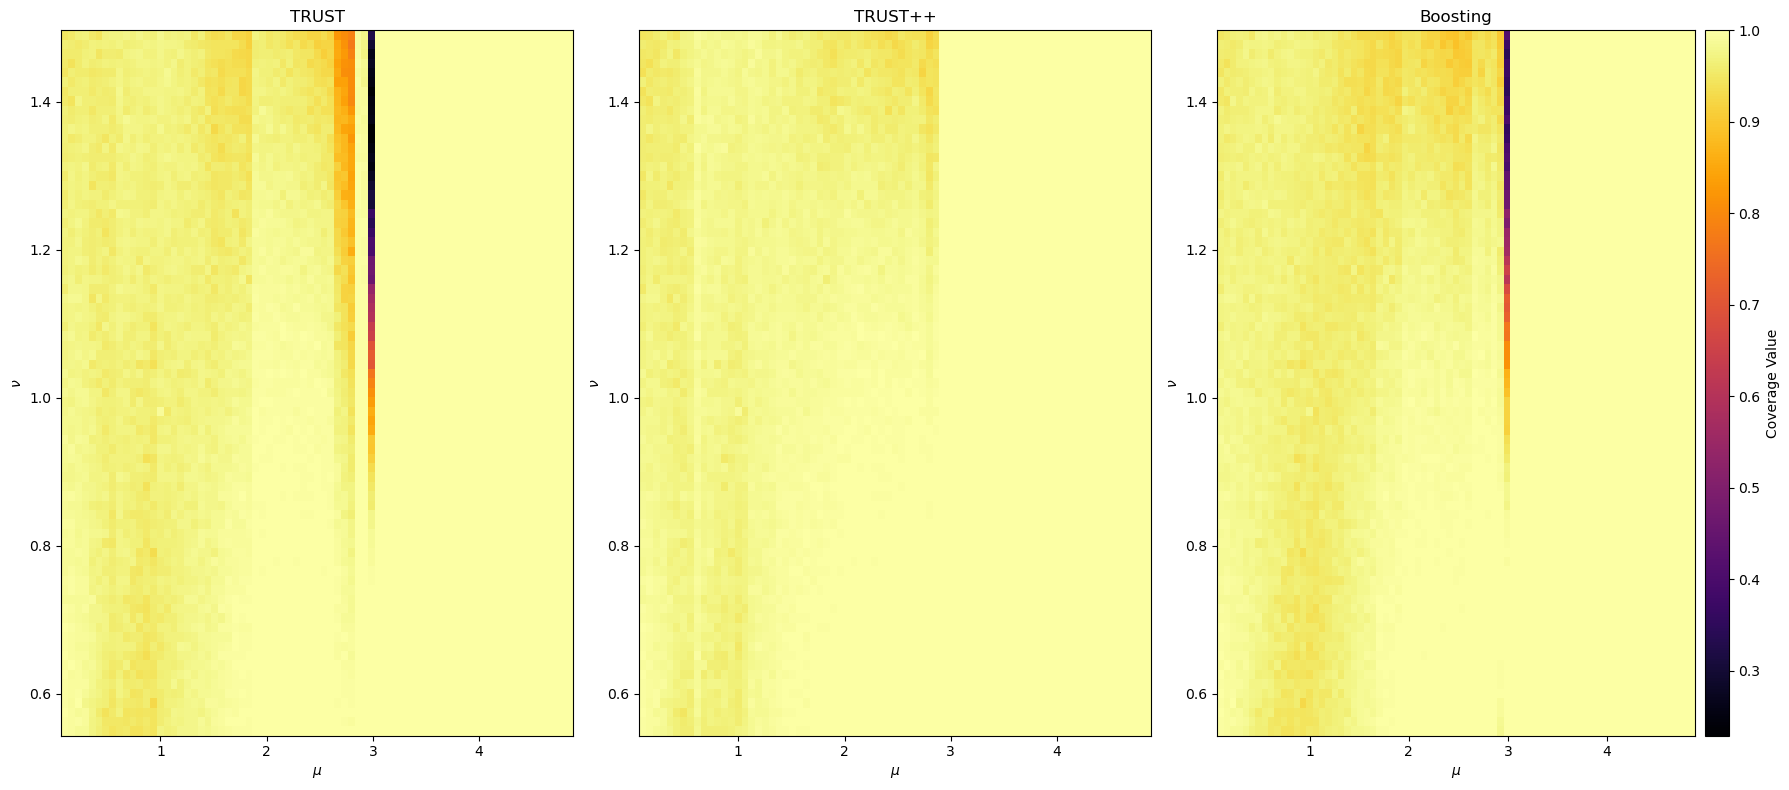

In [26]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
trust_plus_coverage = nuisance_poisson_list[1].reshape(75, 75)
trust_coverage = nuisance_poisson_list[0].reshape(75, 75)
boosting_coverage = nuisance_poisson_list[11].reshape(75, 75)
naive_coverage = nuisance_poisson_list[13].reshape(75, 75)

# Calculate global vmin and vmax
global_vmin = min(
    np.min(trust_plus_coverage), 
    np.min(trust_coverage), 
    np.min(boosting_coverage),
)
global_vmax = max(
    np.max(trust_plus_coverage), 
    np.max(trust_coverage), 
    np.max(boosting_coverage),
)

# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

# Plot TRUST Coverage
pc1 = axes[0].pcolormesh(mu_v, nu_v, trust_coverage, 
                         vmin=global_vmin, 
                         vmax=global_vmax, 
                         cmap='inferno')
axes[0].set_ylabel(r'$\nu$')
axes[0].set_xlabel(r'$\mu$')
axes[0].set_title("TRUST")

# Plot TRUST Plus Coverage
pc2 = axes[1].pcolormesh(
    mu_v, 
    nu_v, 
    trust_plus_coverage, 
    vmin=global_vmin, 
    vmax=global_vmax, 
    cmap='inferno',
    )
axes[1].set_ylabel(r'$\nu$')
axes[1].set_xlabel(r'$\mu$')
axes[1].set_title("TRUST++")


# Plot Boosting Coverage
pc3 = axes[2].pcolormesh(mu_v, nu_v, boosting_coverage, 
                         vmin=global_vmin, 
                         vmax=global_vmax, 
                         cmap='inferno')
axes[2].set_ylabel(r'$\nu$')
axes[2].set_xlabel(r'$\mu$')
axes[2].set_title("Boosting")

# Create a colorbar axis next to the third subplot
divider = make_axes_locatable(axes[2])
cax = divider.append_axes("right", size="5%", pad=0.1)

# Add a common colorbar
cbar = fig.colorbar(pc3, cax=cax)
cbar.set_label('Coverage Value')

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust the right margin to make space for the colorbar

# Show the plot
plt.show()

Plotting heatmap for LOCART cutoffs:

Text(0.5, 1.0, 'TRUST cutoffs')

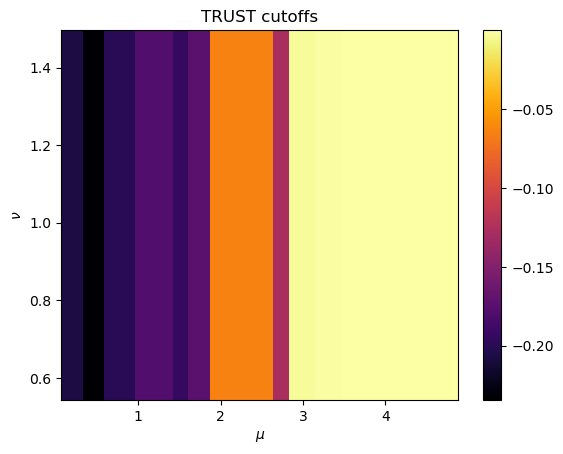

In [27]:
z = nuisance_poisson_list[2].reshape(75, 75)
fig = plt.figure()
pc = plt.pcolormesh(mu_v, 
                    nu_v, 
                    z, 
                    vmin= np.min(nuisance_poisson_list[2]),
                    vmax=np.max(nuisance_poisson_list[2]), 
                    cmap = "inferno")
fig.colorbar(pc)
plt.ylabel(r'$\nu$')
plt.xlabel(r'$\mu$')
plt.title("TRUST cutoffs")

Real cutoffs:

Text(0.5, 1.0, 'Real cutoffs')

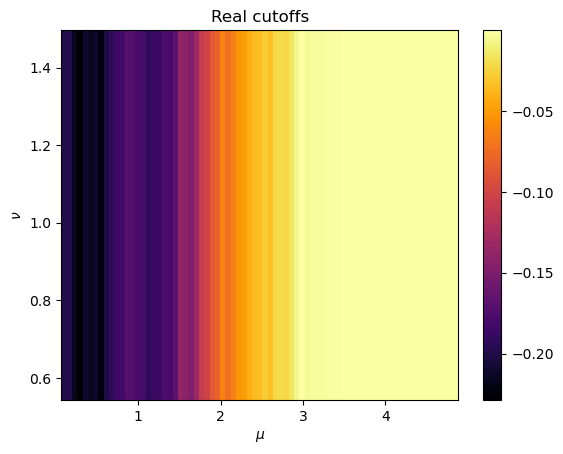

In [28]:
z = nuisance_poisson_list[3].reshape(75, 75)
fig = plt.figure()
pc = plt.pcolormesh(mu_v, 
                    nu_v, 
                    z, 
                    vmin= np.min(nuisance_poisson_list[3]),
                    vmax=np.max(nuisance_poisson_list[3]), 
                    cmap = "inferno")
fig.colorbar(pc)
plt.ylabel(r'$\nu$')
plt.xlabel(r'$\mu$')
plt.title("Real cutoffs")

Text(0.5, 1.0, 'TRUST++ cutoffs')

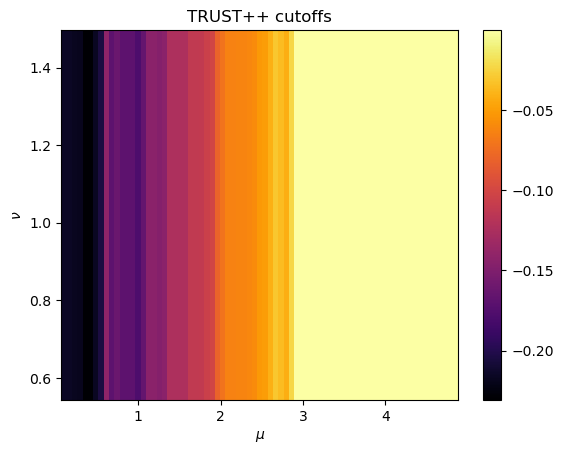

In [29]:
z = nuisance_poisson_list[4].reshape(75, 75)
fig = plt.figure()
pc = plt.pcolormesh(mu_v, 
                    nu_v, 
                    z, 
                    vmin= np.min(nuisance_poisson_list[4]),
                    vmax=np.max(nuisance_poisson_list[4]), 
                    cmap = "inferno")
fig.colorbar(pc)
plt.ylabel(r'$\nu$')
plt.xlabel(r'$\mu$')
plt.title("TRUST++ cutoffs")

Plotting cutoff as a function of $\mu$:

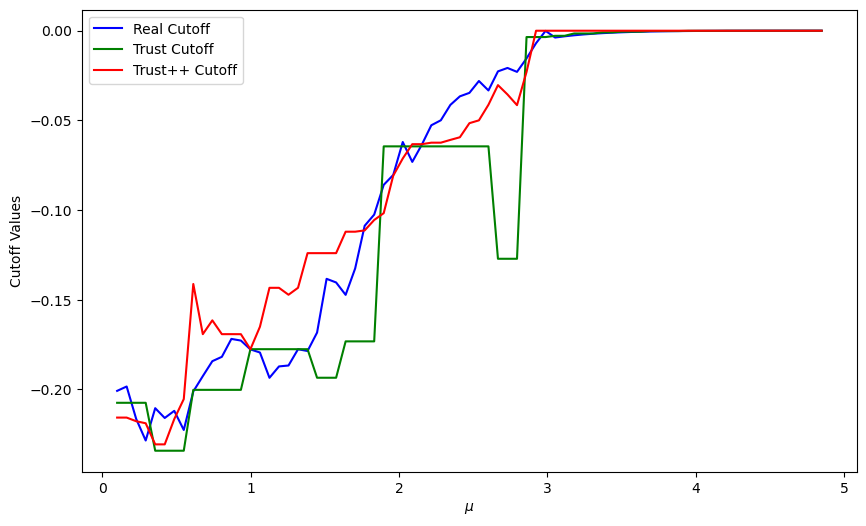

In [30]:
real_mu_cutoff = nuisance_poisson_list[5]
trust_mu_cutoff = nuisance_poisson_list[6]
trust_plus_mu_cutoff = nuisance_poisson_list[7]

# Plot the data
plt.figure(figsize=(10, 6))

plt.plot(mu_space, real_mu_cutoff, label='Real Cutoff', color='blue')
plt.plot(mu_space, trust_mu_cutoff, label='Trust Cutoff', color='green')
plt.plot(mu_space, trust_plus_mu_cutoff, label='Trust++ Cutoff', color='red')

# Add labels and title
plt.xlabel(r'$\mu$')
plt.ylabel('Cutoff Values')
plt.legend()

# Show the plot
plt.show()

#### Plotting and evaluating difference in coverage between each method and the oracle:

Obtaining mean difference of each method coverage compared to the oracle coverage:

In [32]:
trust_plus_coverage = nuisance_poisson_list[1]
trust_coverage = nuisance_poisson_list[0]
boosting_coverage = nuisance_poisson_list[11]
real_cutoffs = nuisance_poisson_list[3]
naive_coverage = nuisance_poisson_list[13]


diff_list = oracle_dist(
    trust_coverage,
    trust_plus_coverage,
    boosting_coverage,
    naive_coverage,
    real_cutoffs,
    valid_thetas,
    simulator = simulator,
    score = bff_score,
    nuisance_idx = 0,
    glm = False,
    seed = 750
)

Repeating computation: 100%|██████████| 50/50 [46:29<00:00, 55.80s/it]


Mean difference to oracle with standard error:

In [33]:
diff_list[4]

,methods,diff,se*2
0,TRUST,0.010593,0.000011
1,TRUST++,0.004646,0.000012
2,Boosting,0.008928,0.000011
3,MC,0.146781,0.000011


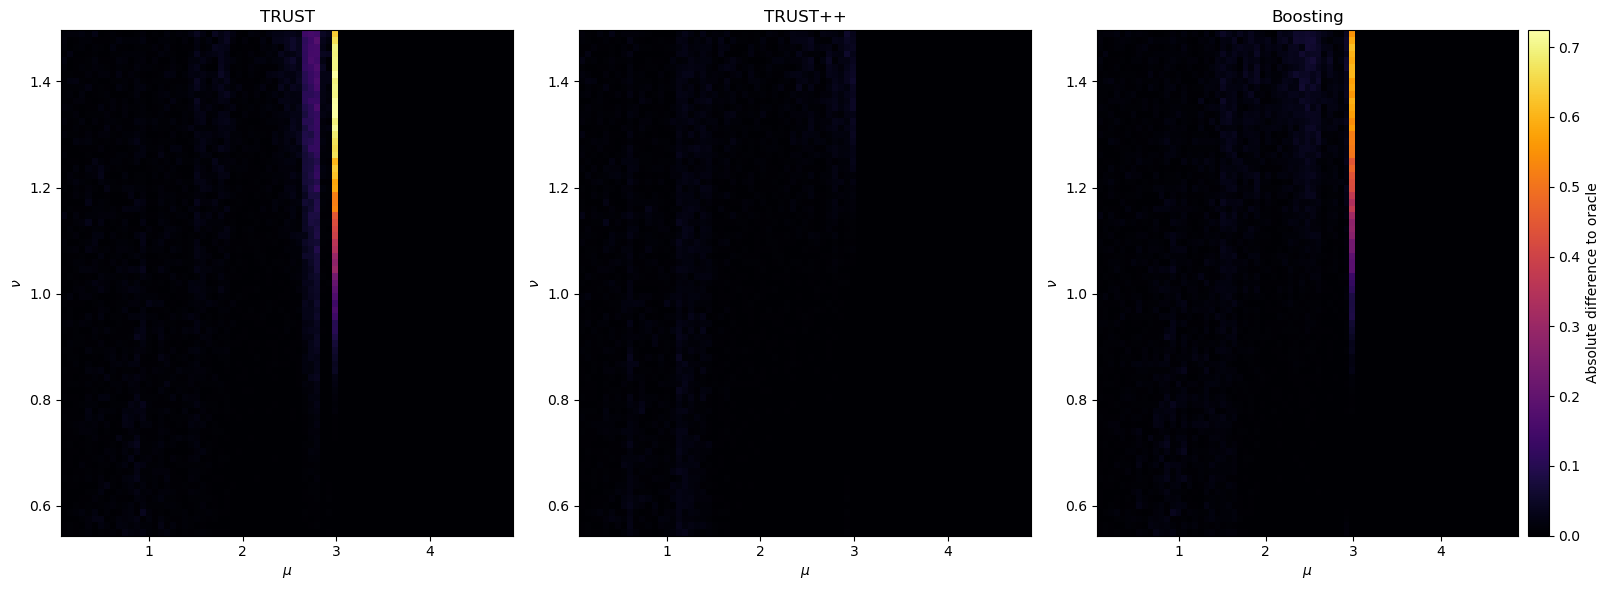

In [37]:
trust_plus_diff = diff_list[1].reshape(75, 75)
trust_diff = diff_list[0].reshape(75, 75)
boosting_diff = diff_list[2].reshape(75, 75)

# Calculate global vmin and vmax
global_vmin = min(
    np.min(trust_plus_diff), 
    np.min(trust_diff), 
    np.min(boosting_diff),
)
global_vmax = max(
    np.max(trust_plus_diff), 
    np.max(trust_diff), 
    np.max(boosting_diff),
)

# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot TRUST Coverage
pc1 = axes[0].pcolormesh(mu_v, nu_v, trust_diff, 
                         vmin=global_vmin, 
                         vmax=global_vmax, 
                         cmap='inferno')
axes[0].set_ylabel(r'$\nu$')
axes[0].set_xlabel(r'$\mu$')
axes[0].set_title("TRUST")

# Plot TRUST Plus Coverage
pc2 = axes[1].pcolormesh(
    mu_v, 
    nu_v, 
    trust_plus_diff, 
    vmin=global_vmin, 
    vmax=global_vmax, 
    cmap='inferno',
    )
axes[1].set_ylabel(r'$\nu$')
axes[1].set_xlabel(r'$\mu$')
axes[1].set_title("TRUST++")


# Plot Boosting Coverage
pc3 = axes[2].pcolormesh(mu_v, nu_v, boosting_diff, 
                         vmin=global_vmin, 
                         vmax=global_vmax, 
                         cmap='inferno')
axes[2].set_ylabel(r'$\nu$')
axes[2].set_xlabel(r'$\mu$')
axes[2].set_title("Boosting")

# Create a colorbar axis next to the third subplot
divider = make_axes_locatable(axes[2])
cax = divider.append_axes("right", size="5%", pad=0.1)

# Add a common colorbar
cbar = fig.colorbar(pc3, cax=cax)
cbar.set_label('Absolute difference to oracle')

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust the right margin to make space for the colorbar

# Show the plot
plt.show()

### GLM model with two parameters, one nuisance:

Implementing simulator and prior for GLM:

In [30]:
# beta_1 parameter space and prior: (-2, 2)
# beta_2 parameter space and prior: (-2, 2)
# beta_0 fixed as 1
# simulating covariate matrix first:
n, alpha_gamma = 80, 1.0

torch.manual_seed(45)
m = Uniform(torch.tensor([-1.0, -1.0]), torch.tensor([1.0, 1.0]))
X = m.sample((n, ))

# adding a column of one in X
X_mat = torch.cat((torch.ones((n, 1)).reshape(-1, 1), X), 1)

# hyperparameters fixed: phi = 1
def prior(n, X_mat):
    m = Uniform(torch.tensor([-2.0, -2.0]), torch.tensor([2.0, 2.0]))
    beta_sample = m.sample((n, ))
    betas = torch.cat((torch.ones((n, 1)).reshape(-1, 1)*(-4), beta_sample), 1)

    # product of betas with X_mat
    mat_rej = torch.sum(
        (torch.mm(betas, torch.transpose(X_mat, 0, 1))) >= 0,
        1
    )
    
    rej_idx = torch.where(mat_rej > 0)
    rej = mat_rej[rej_idx].numel()

    # removing elements from beta_sample
    tensor_list = []
    if rej != 0:
        acept_idx = torch.where(mat_rej == 0)
        if mat_rej[acept_idx].numel() > 0:
            tensor_list.append(beta_sample[acept_idx])
    else:
        tensor_list.append(beta_sample)

    while(rej != 0):
        new_sample = m.sample((rej, ))

        new_betas = torch.cat((torch.ones((rej, 1)), new_sample), 1)

        mat_rej = torch.sum(
        torch.mm(new_betas, torch.transpose(X_mat, 0, 1)) >= 0,
        1
    )
        rej_idx = torch.where(mat_rej > 0)
        # updating rej
        rej = mat_rej[rej_idx].numel()

        if rej == 0:
            tensor_list.append(new_sample)
            break
        else:
            acept_idx = torch.where(mat_rej == 0)
            if mat_rej[acept_idx].numel()  > 0:
                new_sample = new_sample[acept_idx]
                tensor_list.append(new_sample)
    
    # joining all tensors together
    final_betas = torch.cat(tensor_list, axis = 0)
    return final_betas

# simulator using also X and fixing alpha/phi
def simulator(beta, X_mat, alpha = 1.5):
    new_beta = torch.cat(
        (torch.ones((beta.shape[0], 1)).reshape(-1, 1)*(-4), beta), 
        1)

    # computing linear component for each Y
    linear_comp = torch.mm(new_beta, torch.transpose(X_mat, 0, 1))
    phi_par = torch.tensor([alpha]).reshape(1, -1).repeat_interleave(
        repeats = new_beta.shape[0] * X_mat.shape[0]).reshape(
            new_beta.shape[0], X_mat.shape[0])
    
    scale_link = (-1/(phi_par*linear_comp))
    m = Gamma(concentration = phi_par, rate = 1/scale_link)
    return m.sample()

Fitting posterior model for GLM:

Fitting normalizing flows posterior estimator:  33%|███▎      | 661/2000 [04:25<08:57,  2.49it/s]

Early stopping at epoch 661
a


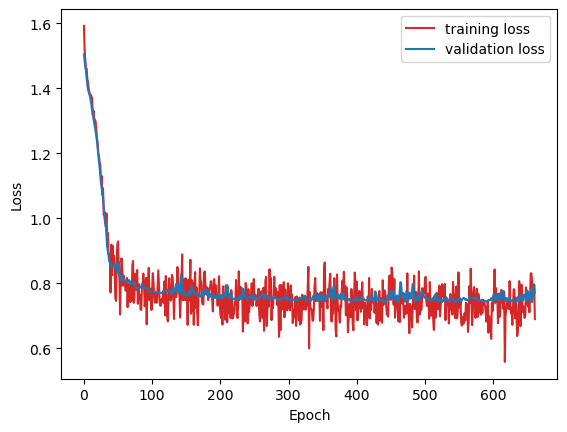

In [31]:
nflow_glm_model = fit_post_model(
    simulator, 
    prior, 
    B_model = 25000, 
    n = 1, 
    seed = 125,
    nuisance_idx = 1, 
    split_seed = 45,
    patience = 200,
    n_flows = 4,
    glm = True,
    alpha = alpha_gamma,
    X_mat = X_mat)

In [32]:
bff_score = BFFScore(nflow_glm_model, is_fitted = True)
bff_score.fit()
B = 15000

Fitting all methods in the glm problem:

In [33]:
torch.manual_seed(125)
torch.cuda.manual_seed(125)

print("Sampling from the parameter prior:")
thetas_sim = prior(B, X_mat)

if thetas_sim.ndim == 1:
    model_thetas = thetas_sim.reshape(-1, 1)
else:
    model_thetas = thetas_sim

# no need of repeating thetas when using X_mat
X_net = simulator(thetas_sim, X_mat, alpha = alpha_gamma)

print("Obtaining statistics sample: ")
model_lambdas = bff_score.compute_nuissance(
    model_thetas.numpy(), X_net.numpy(), nuissance_idx = 1, disable_tqdm=False, posterior_marginalized = True,
    )

print("Fitting our methods: ")
print("Fitting TRUST ")
trust_object = LocartSplit(
        LambdaScore, None, alpha=0.05, is_fitted=True, split_calib=False
    )
trust_quantiles = trust_object.calib(
    model_thetas.numpy(), model_lambdas, min_samples_leaf=300
)

# loforest quantiles
print("Fitting TRUST++")
trust_plus_object = ConformalLoforest(
    LambdaScore, None, alpha=0.05, is_fitted=True, split_calib=False
)
trust_plus_object.calibrate(
    model_thetas.numpy(),
    model_lambdas,
    min_samples_leaf=300,
    n_estimators=200,
    K=70,
)

# training boosting
boosting_object =  HistGradientBoostingRegressor(
        loss="quantile",
        max_iter=100,
        max_depth=3,
        quantile= 0.95,
        random_state=105,
        n_iter_no_change=15,
        early_stopping=True,
    )
boosting_object.fit(model_thetas.numpy(), model_lambdas)

Sampling from the parameter prior:
Obtaining statistics sample: 
Fitting our methods: 
Fitting TRUST 
Fitting TRUST++


HistGradientBoostingRegressor(early_stopping=True, loss='quantile', max_depth=3,
                              n_iter_no_change=15, quantile=0.95,
                              random_state=105)

Fitting monte-carlo also:

In [34]:
naive_quantiles = naive_nuisance(
        kind="glm",
        simulator=simulator,
        score = bff_score,
        nuisance_idx=1,
        alpha=0.05,
        B=B,
        N=n,
        naive_n=500,
        log_transf=False,
        X_mat=X_mat,
        alpha_gamma = alpha_gamma,
    )

fitting monte carlo cutoffs: 36it [00:01, 34.81it/s]


Computing all nuisance cutoffs:

In [35]:
beta_space = np.linspace(-1.9, 1.9, 75)

# returning all combinations for fitting nuissance cutoffs
valid_thetas = np.c_[list(itertools.product(beta_space, beta_space))]

# returning meshgrid for plotting
beta_2_v, beta_1_v = np.meshgrid(beta_space, beta_space)

# obtaining cutoffs for each mu
cutoff_mu_TRUST = TRUST_nuisance_cutoffs(
    trust_object, 
    nuissance_idx = 1, 
    par_values = beta_space.reshape(-1, 1), 
    trust_quantiles = trust_quantiles, 
    )

cutoff_mu_TRUST_plus = TRUST_plus_nuisance_cutoff(
    trust_plus_object,
    nuissance_idx = 1,
    par_values = beta_space.reshape(-1, 1),
    K = 100,
)

cutoff_mu_boosting = boosting_nuisance_cutoff(
    boosting_object, 
    nuisance_grid = np.linspace(-1.9, 1.9, 100), 
    nuissance_idx=1,
    par_values = beta_space.reshape(-1, 1),
    )

cutoff_mu_naive = naive_nuisance_cutoff(
    naive_quantiles,
    nuisance_grid = np.linspace(-1.9, 1.9, 100),
    nuisance_idx = 1,
    par_values = beta_space.reshape(-1, 1),
)

ValueError: zero-size array to reduction operation minimum which has no identity

In [ ]:
nuisance_glm_list = coverage_nuisance(
    cutoff_mu_TRUST, 
    cutoff_mu_TRUST_plus,
    cutoff_mu_boosting, 
    cutoff_mu_naive,
    valid_thetas, 
    par_space = beta_space,
    par_idx = 0,
    nuisance_idx = 1,
    simulator = simulator,
    glm = True,
    score = bff_score,
    n_lambda = 1000,
    X_mat = X_mat,
    alpha_gamma = alpha_gamma,
    ) 

Assessing :   0%|          | 0/5625 [00:00<?, ?it/s]/tmp/ipykernel_14721/2201461194.py:30: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1708025842427/work/torch/csrc/utils/tensor_new.cpp:275.)
  theta_repeated = torch.tensor([theta], dtype = torch.float32).reshape(1, -1).repeat_interleave(repeats = n_lambda, dim = 0)
Computing real cutoffs: 100%|██████████| 5625/5625 [00:00<00:00, 57455.80it/s]


Plotting all coverage together

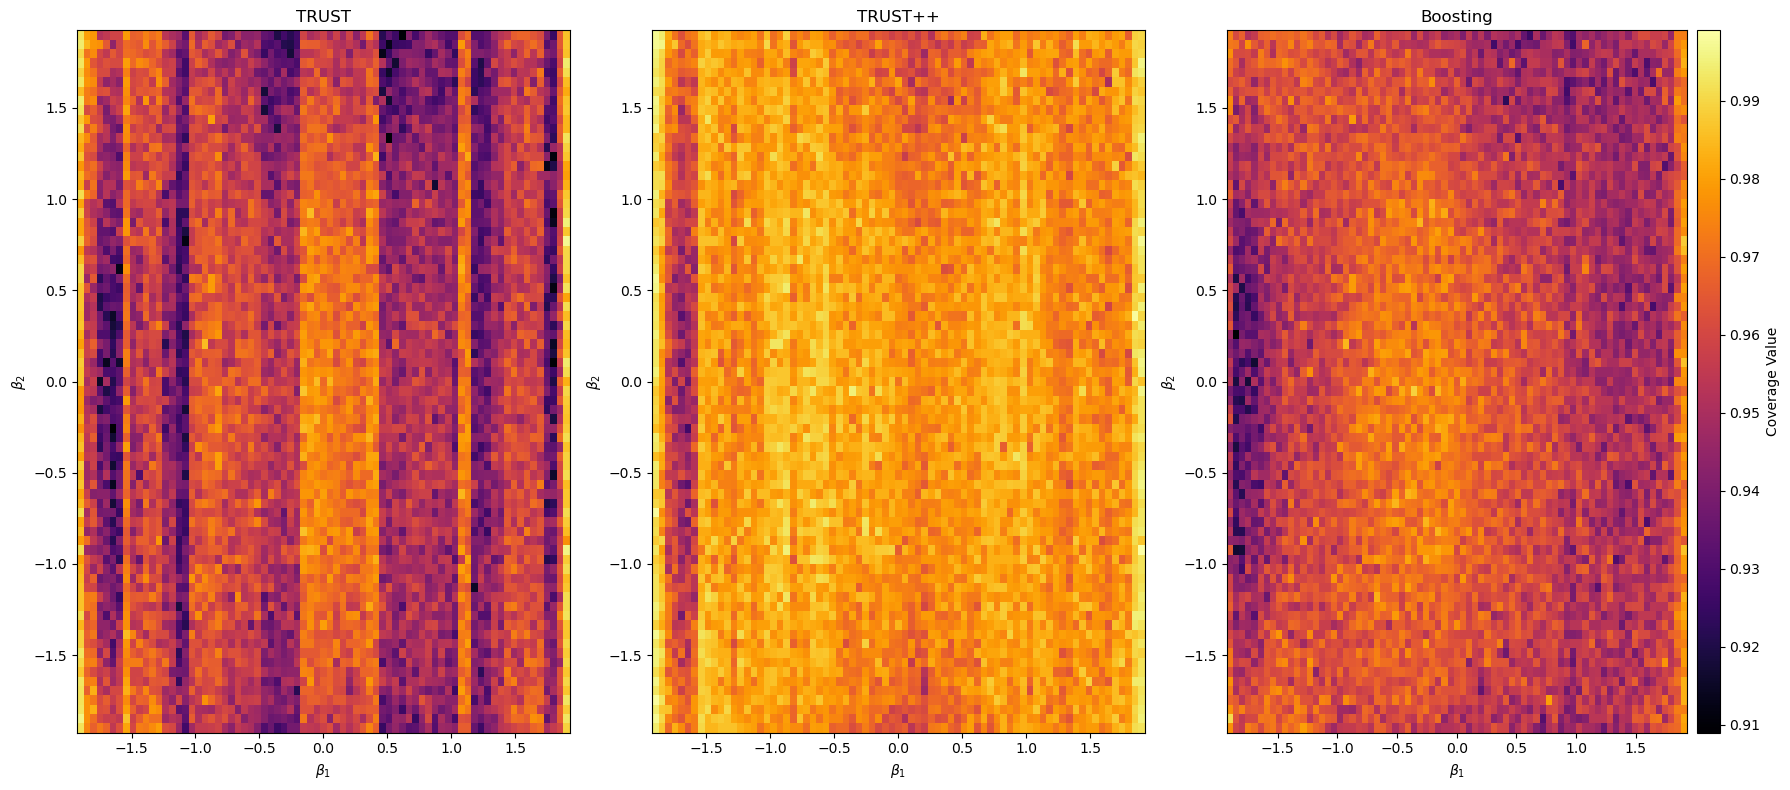

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
trust_plus_coverage = nuisance_glm_list[1].reshape(75, 75)
trust_coverage = nuisance_glm_list[0].reshape(75, 75)
boosting_coverage = nuisance_glm_list[8].reshape(75, 75)
naive_coverage = nuisance_glm_list[10].reshape(75, 75)

# Calculate global vmin and vmax
global_vmin = min(
    np.min(trust_plus_coverage), 
    np.min(trust_coverage), 
    np.min(boosting_coverage),
)
global_vmax = max(
    np.max(trust_plus_coverage), 
    np.max(trust_coverage), 
    np.max(boosting_coverage),
)

# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

# Plot TRUST Coverage
pc1 = axes[0].pcolormesh(beta_1_v, beta_2_v, trust_coverage, 
                         vmin=global_vmin, 
                         vmax=global_vmax, 
                         cmap='inferno')
axes[0].set_ylabel(r'$\beta_2$')
axes[0].set_xlabel(r'$\beta_1$')
axes[0].set_title("TRUST")

# Plot TRUST Plus Coverage
pc2 = axes[1].pcolormesh(
    beta_1_v, 
    beta_2_v, 
    trust_plus_coverage, 
    vmin=global_vmin, 
    vmax=global_vmax, 
    cmap='inferno',
    )
axes[1].set_ylabel(r'$\beta_2$')
axes[1].set_xlabel(r'$\beta_1$')
axes[1].set_title("TRUST++")


# Plot Boosting Coverage
pc3 = axes[2].pcolormesh(beta_1_v, beta_2_v, boosting_coverage, 
                         vmin=global_vmin, 
                         vmax=global_vmax, 
                         cmap='inferno')
axes[2].set_ylabel(r'$\beta_2$')
axes[2].set_xlabel(r'$\beta_1$')
axes[2].set_title("Boosting")

# Create a colorbar axis next to the third subplot
divider = make_axes_locatable(axes[2])
cax = divider.append_axes("right", size="5%", pad=0.1)

# Add a common colorbar
cbar = fig.colorbar(pc3, cax=cax)
cbar.set_label('Coverage Value')

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust the right margin to make space for the colorbar

# Show the plot
plt.show()

Text(0.5, 1.0, 'TRUST++ cutoffs')

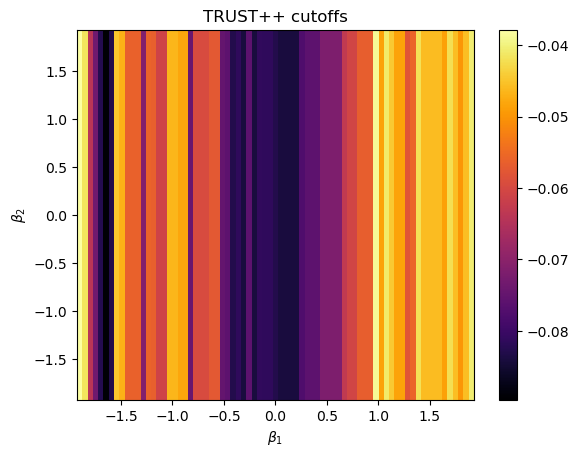

In [ ]:
z = nuisance_glm_list[4].reshape(75, 75)
fig = plt.figure()
pc = plt.pcolormesh(beta_1_v, 
                    beta_2_v, 
                    z, 
                    vmin= np.min(nuisance_glm_list[4]),
                    vmax=np.max(nuisance_glm_list[4]), 
                    cmap = "inferno")
fig.colorbar(pc)
plt.ylabel(r'$\beta_2$')
plt.xlabel(r'$\beta_1$')
plt.title("TRUST++ cutoffs")

Text(0.5, 1.0, 'Real cutoffs')

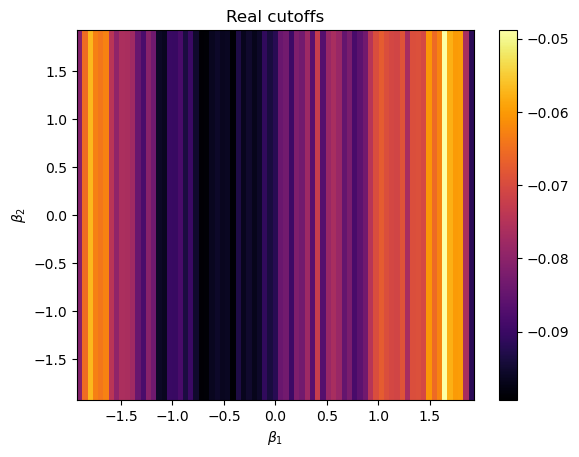

In [ ]:
z = nuisance_glm_list[3].reshape(75, 75)
fig = plt.figure()
pc = plt.pcolormesh(beta_1_v, 
                    beta_2_v, 
                    z, 
                    vmin= np.min(nuisance_glm_list[3]),
                    vmax=np.max(nuisance_glm_list[3]), 
                    cmap = "inferno")
fig.colorbar(pc)
plt.ylabel(r'$\beta_2$')
plt.xlabel(r'$\beta_1$')
plt.title("Real cutoffs")

In [ ]:
trust_plus_coverage = nuisance_glm_list[1]
trust_coverage = nuisance_glm_list[0]
real_cutoffs = nuisance_glm_list[3]
boosting_coverage = nuisance_glm_list[8]
naive_coverage = nuisance_glm_list[10]

diff_list = oracle_dist(
    trust_coverage,
    trust_plus_coverage,
    boosting_coverage,
    naive_coverage,
    real_cutoffs,
    valid_thetas,
    simulator = simulator,
    score = bff_score,
    nuisance_idx = 1,
    n_rep = 10,
    glm = True,
    seed = 350,
    X_mat = X_mat,
    alpha_gamma = alpha_gamma,
)

Repeating computation: 100%|██████████| 10/10 [27:14<00:00, 163.49s/it]


In [ ]:
diff_list[4]

,methods,diff,se*2
0,TRUST,0.014837,0.000027
1,TRUST++,0.012611,0.000031
2,Boosting,0.011028,0.000040
3,MC,0.013140,0.000043
